The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
tensor([[[0.2009, 0.0778, 0.2631, 0.1881, 0.2255]]], grad_fn=<DivBackward0>)


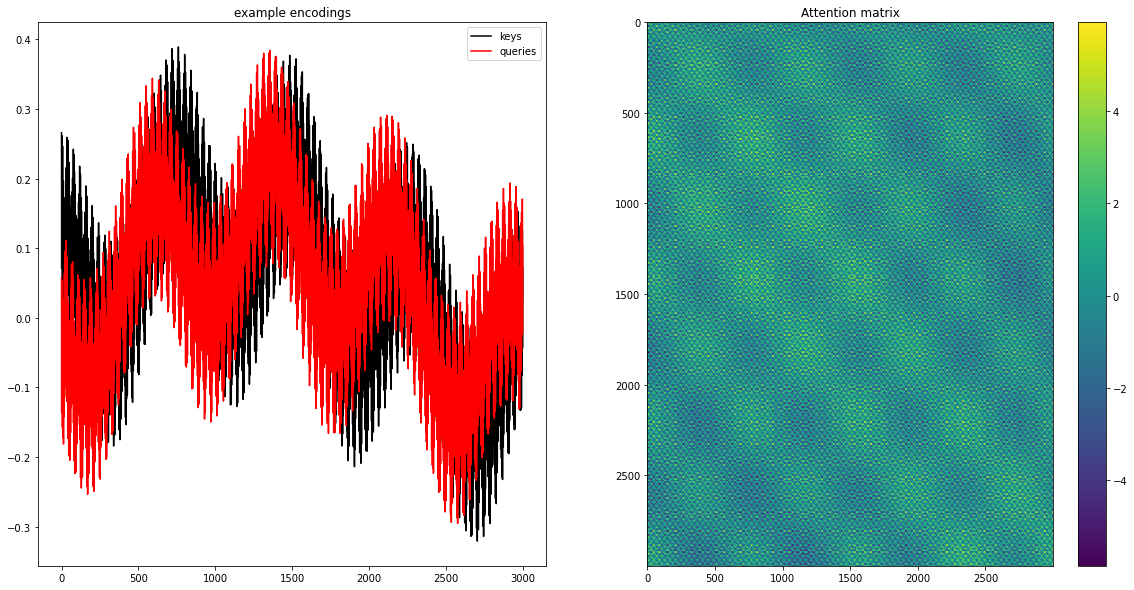

In [27]:
%load_ext autoreload
%autoreload 2

import torch
import spe
import numpy as np
import matplotlib.pyplot as plt
from torch.fft import rfft, irfft
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# sine or conv
conv = False
# dimension for the keys and queries
keys_dim = 1
num_heads = 1
num_realizations = 300
num_sines = 5

# create the positional encoder, with a specified max lag
if conv:
    encoder = spe.ConvSPE(dim=1, keys_dim=keys_dim, kernel_size=500, num_heads=num_heads, num_realizations=num_realizations).to(device)
else:
    encoder = spe.SineSPE(num_heads=num_heads, keys_dim=keys_dim, num_sines=num_sines, num_realizations=256)

# draw keys and queries, as one for the test (activate all patterns)
n = 3000
batchsize=16

# generate some encodings of shape (batchsize, num, n)
q = torch.ones(batchsize, n, num_heads, keys_dim, device=device)
k = torch.ones(batchsize, n, num_heads, keys_dim, device=device)


# compute the average attention matrix
qhat, khat = encoder(q,k)
A = torch.mm(qhat[0,:,0,:].detach(), khat[0,:,0,:].T.detach())

# display some queries and keys
qhat = qhat.detach()
khat = khat.detach()

plt.figure(figsize=[20,10]);
plt.subplot(121)
plt.plot(khat[0,:,0,:1].cpu(),'k');
plt.plot(qhat[0,:,0,:1].cpu(),'r');
plt.title('example encodings');
plt.legend(['keys', 'queries']);

# display the average dot product
plt.subplot(122);
plt.imshow(A.detach().cpu().numpy(), aspect='auto', interpolation='nearest');
plt.title('Attention matrix');
print(torch.sigmoid(encoder.freqs)/2)
plt.colorbar();

In [7]:
N=10
L = 100
H = 8
D=64
queries = torch.rand((N, L, H, D))
dim=1
print(queries.shape)
queries = queries.permute(0, dim + 1, dim + 2, *[d for d in range(1, dim + 1)])
print(queries.shape)

torch.Size([10, 100, 8, 64])
torch.Size([10, 8, 64, 100])


In [27]:
encoder.offsets

Parameter containing:
tensor([[[-1.4684,  1.0536, -0.2404,  0.6756, -0.3045, -0.4371,  0.9345,
          -0.2259,  0.8979,  0.8588]]], requires_grad=True)

torch.Size([50, 1]) torch.Size([100, 10])


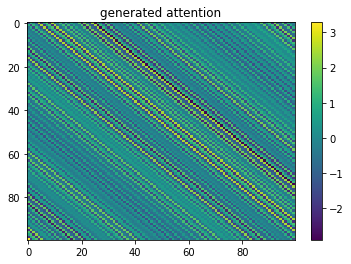

In [146]:
# IDEA: 
#generate random toeplitz matrices with a V_q D V_k^H decomposition
m = 100
n= 100
k=10
r = 128

# generate random frequencies (on the unit circle) exp(i 2 pi f ) with f in [0 1]
v = torch.randn(k, dtype=torch.cfloat, requires_grad=False); v=v/v.abs()

# rotate them according to some positions. (m, k) and (n,k)
Vq = v[None, :] ** torch.linspace(0,1000,m)[:, None]
Vk = v[None, :] ** torch.linspace(1000,2000,n)[:, None]

# draw random weights for each frequency
lamb = torch.rand(k)
#z = lamb[:, None] * torch.randn(k,r, dtype=torch.cfloat)
# compute the encodings
print(z.shape, Vq.shape)
Q= Vq * lamb[None]#Q = torch.mm(Vq,z)
K = Vk * lamb[None]#K = torch.mm(Vk, z)

"""C = torch.mm(Q, torch.conj(K.T)).real
loss = C.abs().sum()
loss.backward()
"""

plt.imshow(torch.mm(Q, torch.conj(K.T)).real.detach().cpu().numpy(), aspect='auto', interpolation='nearest')
plt.title('generated attention')
plt.colorbar()

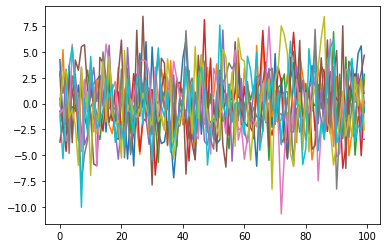

In [98]:
plt.plot(Q[:,:10].real)

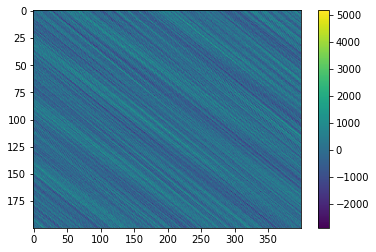

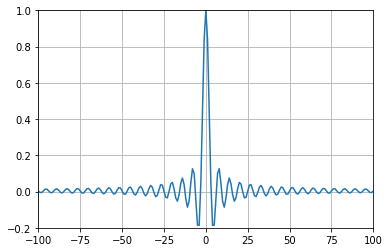

In [5]:
import numpy as np
import matplotlib.pyplot as plt

f = np.linspace(0, 1, 128)
n = np.linspace(-100, 100, 201)

cos_fn = np.sum(np.cos(f[:, None] * n[None, :]), axis=0)

plt.plot(n, cos_fn/np.max(np.abs(cos_fn)))
plt.axis([-100, 100, -0.2, 1])
plt.grid(True)
plt.xlabel('m-n')
plt.ylabel('')
plt.title('The attention pattern for APE')